# CROHME 2023

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


2024-12-29 17:55:27.772785: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-29 17:55:27.881355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735523727.928794    5178 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735523727.942600    5178 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 17:55:28.049374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


Import `crohme_dataset`

In [2]:
import datasets.crohme_dataset  # Register `crohme_dataset`

ds = tfds.load("crohme_dataset")  # `crohme_dataset` registered
test: tf.data.Dataset = ds["test"]
train: tf.data.Dataset = ds["train"]
validation: tf.data.Dataset = ds["validation"]

I0000 00:00:1735523731.991222    5178 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5565 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


### Extra: Previewing InkML Files

I also created a little utility in C++ and GTK to render out an inkml file from the dataset. It reads the InkML file, and renders out the strokes as well as the LaTeX of what it's supposed to be. It was a fun project!

In [3]:
import os

random_data_point = next(iter(validation.shuffle(200_000).take(1)))
filepath = random_data_point["filepath"].numpy().decode("ascii")
os.system(f"inkmlviewer {filepath}")

2024-12-29 17:55:34.796456: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


/home/jeshwinprince/Programming/crohme/datasets/crohme_dataset/data/INKML/val/CROHME2016_test/UN_451_em_606.inkml
Displaying app now...


0

## Preprocessing

### Text Vectorization

We will use `pylatexenc` to parse the LaTeX into nodes for custom splitting

In [4]:
from pylatexenc.latexwalker import (
    LatexWalker,
    LatexMacroNode,
    LatexEnvironmentNode,
    LatexCharsNode,
    LatexGroupNode,
    LatexMathNode,
)

START_TOKEN, END_TOKEN = "<START>", "<END>"


# Define the tokenization function using pylatexenc
def latex_tokenizer(latex_string):
    """
    Tokenizes a LaTeX string into tokens using pylatexenc.
    """
    if not latex_string:
        return []
    walker = LatexWalker(latex_string)

    def parse_node(nodelist):
        if len(nodelist) == 0:
            return []
        try:
            tokens = []
            for node in nodelist:
                if not node:
                    continue
                elif node.isNodeType(LatexMacroNode):
                    tokens.append(f"\\{node.macroname}")
                    # Parse arguments if they exist
                    tokens += parse_node(node.nodeargd.argnlist)
                elif node.isNodeType(LatexEnvironmentNode):
                    tokens.append(f"\\begin{{{node.environmentname}}}")
                    tokens += parse_node(node.nodeargd.argnlist)
                    tokens += parse_node(node.nodelist)
                    tokens.append(f"\\end{{{node.environmentname}}}")
                elif node.isNodeType(LatexCharsNode):
                    tokens += list(node.chars)
                elif node.isNodeType(LatexGroupNode):
                    tokens.append(node.delimiters[0])
                    tokens += parse_node(node.nodelist)
                    tokens.append(node.delimiters[1])
                elif node.isNodeType(LatexMathNode):
                    tokens.append(node.delimiters[0])
                    tokens += parse_node(node.nodelist)
                    tokens.append(node.delimiters[1])
            return tokens
        except Exception as e:
            return []

    nodelist, _, _ = walker.get_latex_nodes()
    return parse_node(nodelist)


# Wrap the tokenizer for use in TextVectorization
def tokenize_fn(latex_tensor):
    tokens = []
    for latex_string in latex_tensor:
        tokenized_string = latex_tokenizer(latex_string.numpy().decode("utf-8"))
        tokenized_string.insert(0, START_TOKEN)
        tokenized_string.append(END_TOKEN)
        tokens.append(tokenized_string)
    return tf.ragged.constant(tokens, dtype=tf.string)


# Create a TensorFlow-compatible wrapper
def tf_tokenizer(latex_string):
    return tf.py_function(
        func=tokenize_fn,
        inp=[latex_string],
        Tout=tf.RaggedTensorSpec([None, None], dtype=tf.string),
    )

Create the vectorizer and use a vocabulary file to adapt it

In [ ]:
# Create the TextVectorization layer
max_tokens = 10_000  # Adjust depending on your vocabulary size

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize=None,  # Custom tokenizer, so no built-in preprocessing
    split=tf_tokenizer,
    ragged=True,
)
dataset = tf.data.TextLineDataset("vocabulary.txt")
dataset = dataset.map(lambda line: [line])
vectorizer.adapt(dataset)

Test it out to make sure it works properly

In [ ]:
def latex_to_token(string):
    return vectorizer(string)


id_to_token = {i: token for i, token in enumerate(vectorizer.get_vocabulary())}


def token_to_latex(tokens):
    return "".join([id_to_token[id] for id in tokens.numpy()])


latex_array = [
    r"E = mc^2",
    r"\frac{a}{b} + \sqrt{c}",
    r"\sum_{i=1}^n i^2 = \frac{n(n+1)(2n+1)}{6}",
    r"A = \pi r^2",
    r"G=\begin{bmatrix}1&\dots&1&0&\dots&0\\ \ast&\ast&\ast&&G^{\prime}&\\ \end{bmatrix}",
]
latex_data = tf.constant(latex_array)

# Tokenize and vectorize
tokenized_output = latex_to_token(latex_data)
print(tokenized_output)

E_mc2 = token_to_latex(tokenized_output[0])
print(E_mc2)

Save the vocabulary just in case. You would still need the custom latex parser function imported to use it in another project

In [ ]:
with open("vectorizer_vocabulary.txt", "w") as f:
    for word in vectorizer.get_vocabulary():
        f.write(word)
        f.write("\n")

## Re-Create Vectorizer

To re-create the vectorizer using the vocabulary, run the following code

In [5]:
max_tokens = 10_000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize=None,  # Custom tokenizer, so no built-in preprocessing
    split=tf_tokenizer,
    ragged=True,
)
with open("vectorizer_vocabulary.txt", "r") as f:
    lines = [line[:-1] for line in f]
    vectorizer.set_vocabulary(lines)

Test it out to make sure it works properly

In [6]:
def latex_to_token(string):
    return vectorizer(string)

id_to_token = {i: token for i, token in enumerate(vectorizer.get_vocabulary())}


def token_to_latex(tokens):
    return "".join([id_to_token[id] for id in tokens.numpy()])


latex_array = [
    r"E = mc^2",
    r"\frac{a}{b} + \sqrt{c}",
    r"\sum_{i=1}^n i^2 = \frac{n(n+1)(2n+1)}{6}",
    r"A = \pi r^2",
    r"G=\begin{bmatrix}1&\dots&1&0&\dots&0\\ \ast&\ast&\ast&&G^{\prime}&\\ \end{bmatrix}",
    r"$R^2$",
]
latex_data = tf.constant(latex_array)

# Tokenize and vectorize
tokenized_output = latex_to_token(latex_data)
print(tokenized_output)

E_mc2 = token_to_latex(tokenized_output[0])
print(E_mc2)

<tf.RaggedTensor [[4, 60, 45, 11, 45, 30, 39, 9, 12, 5],
 [4, 20, 3, 21, 2, 3, 38, 2, 45, 18, 45, 79, 3, 39, 2, 5],
 [4, 73, 6, 3, 19, 11, 10, 2, 9, 16, 45, 19, 9, 12, 45, 11, 45, 20, 3, 16,
  7, 16, 18, 10, 8, 7, 12, 16, 18, 10, 8, 2, 3, 92, 2, 5]                 ,
 [4, 34, 45, 11, 45, 78, 27, 9, 12, 5],
 [4, 76, 11, 165, 10, 154, 10, 17, 154, 17, 75, 45, 245, 245, 245, 76, 9, 3,
  69, 2, 75, 45, 164, 5]                                                    ,
 [4, 1, 42, 9, 12, 1, 5]]>
<START>E = mc^2<END>


Try an actual data point

In [7]:
random_data_point = next(iter(validation.take(1)))
tokenized_data_point = latex_to_token([random_data_point['ground_truth'].numpy()])
print(tokenized_data_point)
detokenized_data_point = token_to_latex(tokenized_data_point[0])
print(detokenized_data_point)

<tf.RaggedTensor [[4, 15, 10, 29, 127, 77, 77, 5]]>
<START>-1.955<END>


### Preprocessing Strokes

Instead of images, this model takes in a stream of strokes, such as writing with a stylus on a tablet. Our dataset gives us a list of strokes, and each stroke is itself a list of coordinates [x, y] of the position of the stylus. Both the number of strokes and the length of each strokes changes for every value in our dataset, so we are going to pre-process the stroke data so it will be normalized (scaled to be between 0 and 1), and always fit in a tensor with shape `(64, 64, 2,)`. FOr this, I am using the [Ramer-Douglas-Peucker Algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) for polyline decimation.

In [8]:
@tf.function
def preprocess_strokes(strokes: tf.RaggedTensor):
    # First, scale values to between 0.0 and 1.0
    min_vals = tf.reduce_min(strokes, axis=(0, 1))
    max_vals = tf.reduce_max(strokes, axis=(0, 1))
    normalized_strokes = tf.map_fn(
        elems=strokes,
        fn=lambda stroke: (stroke - min_vals) / (max_vals - min_vals + 1e-6),
    )

    def point_line_distance(point, start, end):
        """
        Calculate the perpendicular distance from `point` to the line segment
        defined by `start` and `end`.
        """
        # Convert to 3D by adding a zero z-component
        point_3d = tf.concat([point, tf.zeros([1], dtype=tf.float32)], axis=0)
        start_3d = tf.concat([start, tf.zeros([1], dtype=tf.float32)], axis=0)
        end_3d = tf.concat([end, tf.zeros([1], dtype=tf.float32)], axis=0)

        # Return the perpendicular distance (norm of the cross product / norm of the line segment)
        return tf.norm(
            tf.linalg.cross(end_3d - start_3d, point_3d - start_3d)
        ) / tf.norm(end_3d - start_3d)

    def douglas_peucker(stroke, epsilon=0.01):
        """
        Non-recursive Douglas-Peucker algorithm implementation.
        """

        # Initialize the list of points to keep
        simplified_stroke: tf.TensorArray = tf.TensorArray(
            dtype=stroke.dtype, size=0, dynamic_size=True
        ).write(0, stroke[0])

        # Stack for processing: Each entry contains a tuple (start_index, end_index)
        stack: tf.TensorArray = tf.TensorArray(
            dtype=tf.int32, size=0, dynamic_size=True
        ).write(0, [0, tf.shape(stroke)[0] - 1])

        def cond(stack: tf.TensorArray, _simplified_stroke: tf.TensorArray):
            return tf.not_equal(stack.size(), 0)

        def body(stack: tf.TensorArray, simplified_stroke: tf.TensorArray):
            # Pop from the stack
            border_idxs = stack.read(stack.size() - 1)
            start_idx, end_idx = border_idxs[0], border_idxs[1]

            if stack.size() > 1:
                new_stack_tensor = stack.gather(tf.range(stack.size() - 1))
                # Create a new stack with the remaining elements
                new_stack = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
                for i in tf.range(stack.size() - 1):
                    new_stack = new_stack.write(i, new_stack_tensor[i])
                stack = new_stack
            else:
                stack = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

            # Get the relevant slice of the stroke
            sub_stroke = stroke[start_idx : end_idx + 1]

            # Calculate the perpendicular distances of all intermediate points
            start, end = sub_stroke[0], sub_stroke[-1]

            distances = tf.vectorized_map(
                elems=sub_stroke[1:-1], fn=lambda p: point_line_distance(p, start, end)
            )

            if tf.size(distances) > 1:
                max_distance = tf.reduce_max(distances)
                max_idx = (
                    tf.argmax(distances, output_type=tf.int32) + 1
                )  # +1 because we skip the start point

                # If the max distance is greater than epsilon, continue splitting
                if max_distance > epsilon:
                    stack = stack.write(stack.size(), [start_idx, start_idx + max_idx])
                    stack = stack.write(stack.size(), [start_idx + max_idx, end_idx])
                else:
                    # Otherwise, keep the start and end points
                    simplified_stroke = simplified_stroke.write(
                        simplified_stroke.size(), end
                    )
            elif tf.size(distances) == 1:
                if distances > epsilon:
                    stack = stack.write(stack.size(), [start_idx, start_idx + 1])
                    stack = stack.write(stack.size(), [start_idx + 1, end_idx])
                else:
                    simplified_stroke = simplified_stroke.write(
                        simplified_stroke.size(), end
                    )
            else:
                # If no intermediate points exist, just keep the start and end points
                simplified_stroke = simplified_stroke.write(
                    simplified_stroke.size(), end
                )

            return stack, simplified_stroke

        # Return the simplified stroke
        return tf.while_loop(cond, body, [stack, simplified_stroke])[1].stack()

    downsampled_strokes = tf.map_fn(elems=normalized_strokes, fn=douglas_peucker)
    return downsampled_strokes

Let's try it out first!

In [9]:
random_data_point = next(iter(validation.shuffle(100_000).take(1)))
# print(random_data_point['strokes'])
print(preprocess_strokes(random_data_point["strokes"]))

<tf.RaggedTensor [[[0.0, 0.22264872],
  [0.006799169, 0.63915545]], [[0.030334735, 0.21305175],
                               [0.03922594, 0.7005757]]  ,
 [[0.0037918403, 0.41842616],
  [0.059492677, 0.3646832],
  [0.047594145, 0.390595]]   , [[0.06380753, 0.4836853],
                                [0.09505753, 0.48080596]],
 [[0.06589958, 0.62188095],
  [0.10094141, 0.59213036]], [[0.10917887, 0.2552783],
                              [0.1439592, 0.30902106],
                              [0.14422071, 0.042226538],
                              [0.1294456, 0.1986564]]   ,
 [[0.1484048, 0.4884837],
  [0.18854602, 0.4654509],
  [0.18096234, 0.49712095]], [[0.15023534, 0.73032635],
                              [0.19011506, 0.9433779],
                              [0.15808053, 0.99712086],
                              [0.1453975, 0.9846448],
                              [0.16566423, 0.7216891],
                              [0.16056485, 0.69577736]],
 [[0.22528765, 0.42706323],
  [0

In [11]:
random_data_point = next(iter(validation.shuffle(200_000).take(1)))
print(random_data_point["strokes"])
print(preprocess_strokes(random_data_point["strokes"]))
# filepath = random_data_point["filepath"].numpy().decode("ascii")
# os.system(f"inkmlviewer {filepath}")

<tf.RaggedTensor [[[35.32, 146.71],
  [35.31, 146.68],
  [35.29, 146.6],
  [35.29, 146.53],
  [35.31, 146.44],
  [35.34, 146.34],
  [35.38, 146.23],
  [35.44, 146.1],
  [35.52, 145.96],
  [35.61, 145.8],
  [35.72, 145.62],
  [35.84, 145.41],
  [35.96, 145.21],
  [36.07, 144.99],
  [36.19, 144.79],
  [36.3, 144.6],
  [36.39, 144.45],
  [36.46, 144.34],
  [36.5, 144.27],
  [36.51, 144.25],
  [36.51, 144.25],
  [36.51, 144.26],
  [36.51, 144.29],
  [36.5, 144.34],
  [36.5, 144.44],
  [36.47, 144.61],
  [36.44, 144.9],
  [36.41, 145.26],
  [36.37, 145.7],
  [36.34, 146.14],
  [36.33, 146.54],
  [36.33, 146.88],
  [36.34, 147.13],
  [36.38, 147.34],
  [36.43, 147.49],
  [36.49, 147.59],
  [36.55, 147.66],
  [36.62, 147.71],
  [36.7, 147.7],
  [36.8, 147.64],
  [36.93, 147.53],
  [37.09, 147.36],
  [37.25, 147.13],
  [37.41, 146.84],
  [37.56, 146.53],
  [37.71, 146.22],
  [37.84, 145.88],
  [37.97, 145.56],
  [38.07, 145.28],
  [38.16, 145.01],
  [38.22, 144.81],
  [38.26, 144.66],
  [38.29

### Preprocessing datasets

Now, we can go through our datasets a preprocess all the data. We will need both our vectorizer and our stroke preprocessor together. Since we are going with an encoder-decoder model, we need input data for the decoder as well, which should be the desired output, but just missing the last token, and with the start token added in front.

In [10]:
def preprocess_data(data):
    input_strokes = preprocess_strokes(data["strokes"]).to_tensor(default_value=0.0, shape=(48, 32, 2,))
    ground_truth = latex_to_token([data["ground_truth"]])
    decoder_input = ground_truth[0][:-1]
    decoder_output = ground_truth[0][1:]
    return (input_strokes, decoder_input), decoder_output

In [11]:
for data in test.shuffle(200_000).take(20).map(preprocess_data):
    # pp_data = preprocess_data(data)
    # pp_data = data
    # print("Input Stroke Shape:", tf.shape(data[0][0]))
    print("Decoder input:", token_to_latex(data[0][1]))
    print("True value:", token_to_latex(data[1]))

Decoder input: <START>\sum^n_{i=1} x_i = 1
True value: \sum^n_{i=1} x_i = 1<END>
Decoder input: <START>(1-\cos\theta)^q
True value: (1-\cos\theta)^q<END>
Decoder input: <START>z=[(a-c)+(a+c)\cos\theta]/2
True value: z=[(a-c)+(a+c)\cos\theta]/2<END>
Decoder input: <START>y=x^{p+1}
True value: y=x^{p+1}<END>
Decoder input: <START>6(a-d)+7(a-b)
True value: 6(a-d)+7(a-b)<END>
Decoder input: <START>S_{eff} = \intdt \intdr L
True value: S_{eff} = \intdt \intdr L<END>
Decoder input: <START>\frac{1}{12}n^2(n^2-1)
True value: \frac{1}{12}n^2(n^2-1)<END>
Decoder input: <START>[UNK]\summ^2[UNK]
True value: [UNK]\summ^2[UNK]<END>
Decoder input: <START>[UNK]x_1^2 + x_2^2 + x_3^2 = 1[UNK]
True value: [UNK]x_1^2 + x_2^2 + x_3^2 = 1[UNK]<END>
Decoder input: <START>\lambda(a)=4\sqrt{1+2a}-3(1+a)
True value: \lambda(a)=4\sqrt{1+2a}-3(1+a)<END>
Decoder input: <START>\frac{-i}{\sqrt{2}}
True value: \frac{-i}{\sqrt{2}}<END>
Decoder input: <START>[UNK]cc(ca)[UNK]
True value: [UNK]cc(ca)[UNK]<END>
Decoder in

2024-12-29 17:56:32.803627: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
shuffled_test = test.shuffle(200_000)
shuffled_train = train.shuffle(200_000)
shuffled_validation = validation.shuffle(200_000)

pp_test = shuffled_test.map(preprocess_data).padded_batch(32).prefetch(tf.data.AUTOTUNE)
pp_train = (
    shuffled_train.map(preprocess_data).padded_batch(32).prefetch(tf.data.AUTOTUNE)
)
pp_validation = (
    shuffled_validation.map(preprocess_data).padded_batch(32).prefetch(tf.data.AUTOTUNE)
)

Let's test this out to make sure it worked!

In [13]:
print(next(iter(pp_validation.take(1))))

((<tf.Tensor: shape=(32, 48, 32, 2), dtype=float32, numpy=
array([[[[0.        , 0.14851485],
         [0.25797874, 0.6930693 ],
         [0.22340426, 0.76237625],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.45212767, 0.6039604 ],
         [0.5053192 , 0.9405941 ],
         [0.47606382, 0.96039605],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.6888298 , 0.22772278],
         [0.84574467, 0.7821782 ],
         [0.80851066, 0.75247526],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        ...,

        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0

## Model Architecture

My model is an encoder-decoder architecture, with a CNN for the encoder, a feedforward network to get to the latent space, and a LSTM RNN for the decoder.

### Encoder

In [14]:
input_strokes = layers.Input(shape=(48, 32, 2), name="Encoder_Input")
x = layers.Conv2D(64, kernel_size=(3, 3), padding="same")(input_strokes)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

latent_space = layers.Dense(1024, activation="relu", name="Latent_Space")(x)
latent_space = layers.Dense(512, activation="relu")(latent_space)
latent_space = layers.Dense(512, activation="relu")(latent_space)
latent_space = layers.Dense(512, activation="relu")(latent_space)
latent_space = layers.Dense(512, activation="relu")(latent_space)

### Decoder

In [15]:
latent_space_h = layers.Dense(256, activation="relu", name="LSTM_Hidden_Layer")(latent_space)
latent_space_c = layers.Dense(256, activation="relu", name="LSTM_Cell_Layer")(latent_space)

decoder_input = layers.Input(shape=(None,), name="Decoder_Input")
decoder_embedding = layers.Embedding(input_dim=vectorizer.vocabulary_size(), output_dim=128, name="Decoder_Embedding")(
    decoder_input
)
decoder_lstm = layers.LSTM(256, return_sequences=True, name="Decoder_LSTM")
decoder_output = decoder_lstm(
    decoder_embedding, initial_state=[latent_space_h, latent_space_c]
)

### Output

In [16]:
output = layers.Dense(vectorizer.vocabulary_size(), activation="softmax", name="Decoder_Output")(decoder_output)
model = keras.Model([input_strokes, decoder_input], output)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 48, 32, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 32,    │      1,216 │ Encoder_Input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 8,     │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 8,     │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 4, 256) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 4, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 2, 512) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3072)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Latent_Space        │ (None, 1024)      │  3,146,752 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    524,800 │ Latent_Space[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, None, 128) │    123,648 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Hidden_Layer   │ (None, 256)       │    131,328 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Cell_Layer     │ (None, 256)       │    131,328 │ dense_3[0][0]   

 Total params: 7,038,726 (26.85 MB)

 Trainable params: 7,038,726 (26.85 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

Now we can finally train our model! We have a ton of training and validation data to use. We'll also save the history so we can get a graph of the change in loss over each epoch.

In [ ]:
history = model.fit(
    pp_train,
    validation_data=pp_validation,
    epochs=20,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("model_checkpoint.keras", save_best_only=True),
    ],
)

Epoch 1/20


I0000 00:00:1735523873.550391    6523 cuda_dnn.cc:529] Loaded cuDNN version 90300


 299/4918 ━━━━━━━━━━━━━━━━━━━━ 16:41 217ms/step - accuracy: 0.7408 - loss: 1.6578

## Analyzing the Model

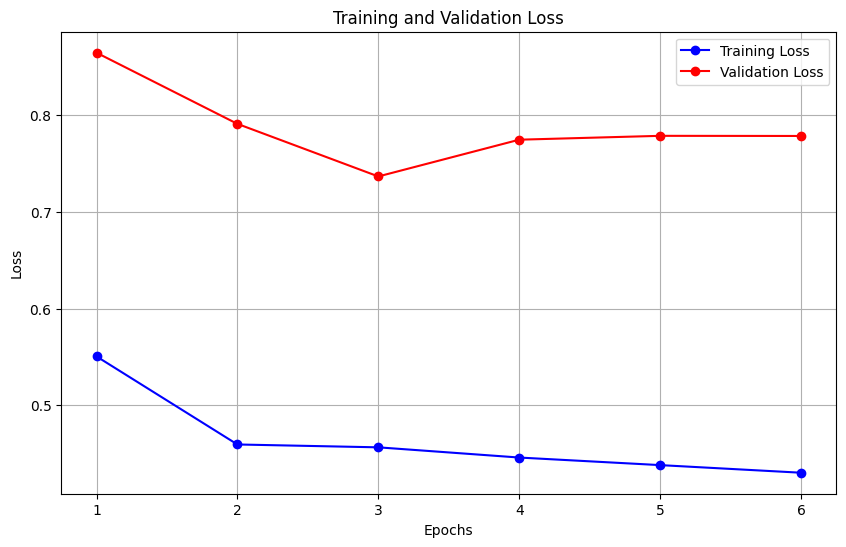

In [20]:
# Retrieve the loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # Blue dots for training loss
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # Red dots for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plot
plt.show()